In [1]:
#数据预处理
%matplotlib inline
import numpy as np
#import torch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
#import missingno as msno

#不加下面这一步进程很容易中断
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ["OMP_NUM_THREADS"] = '9' 

#---------------------------------------------------
import sklearn
from sklearn import metrics
from sklearn.metrics import RocCurveDisplay
#加载模型：
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn import linear_model

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier

#---------------------------
from sklearn.model_selection import GridSearchCV

In [2]:
#网络调参函数 for img+sub
def get_model(name):
    if name=="SVC":
        clf=GridSearchCV(
            svm.SVC(),
            {
                #核
                "kernel": ['linear', "poly"],
                #惩罚系数
                "C": [0.01,0.1,1]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="DT":
        clf=GridSearchCV(
            tree.DecisionTreeClassifier(),
            {
                #划分方式
                "criterion": ['entropy',"gini"],#前者是基尼系数，后者是信息熵
                #z最大深度
                "max_depth": [2,10,50,100,200,500] ,
                #可以分支的最少样本数
                "min_samples_split": [1,5,10,20] ,
                #叶节点最小样本数
                "min_samples_leaf": [1,5,10,20] ,
                #信息增益最小值
                "min_impurity_decrease": [0.001,0.01]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="LR":
        clf = GridSearchCV(
            linear_model.LogisticRegression(),
            {
                "penalty":[None,'l2',"l1"],
                "C":[1,2,3,4,5,6,7,8,9,10],
                "solver":["newton-cg", "lbfgs", "liblinear", "sag"],
                "class_weight":["balanced",None]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="NB":
        clf = GridSearchCV(
            GaussianNB(),
            {},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
        
    if name=="KNN":
        clf = GridSearchCV(
            KNeighborsClassifier(),
            {
                "n_neighbors": [3,5,10,12]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="RF":
        clf = GridSearchCV(
            RandomForestClassifier(),
            {
                "n_estimators" : [10,15,20,25,30],
                "criterion" : ["entropy","gini"],
                "max_depth" : [8,12,16,20],
                "min_samples_split" : [2,3,4,5],
                "min_samples_leaf" : [1,2,3,4,5]
            },
            #{
            #    "n_estimators" : [10,20,30,50,80],
            #    "criterion" : ["entropy","gini"],
            #    "max_depth" : [4,8,12,None],
            #    "min_samples_split" : [2,5,10],
            #    "min_samples_leaf" : [1,5,10,20]
            #},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="XB":
        clf=GridSearchCV(
            XGBClassifier(),
            {
                "n_estimators":[5,10,15,20],  # 树的个数-10棵树建立xgboost
                "max_depth":[6,12,18,24,30],  # 树的深度[4,8,12]
                "min_child_weight":[0.5,0.6,0.7],#叶子上最小样本数,值越大，越容易欠拟合；值越小，越容易过拟合
                "scale_pos_weight":[2.4,2.5],#各类别样本十分不平衡时，把这个参数设定为一个正值
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    return clf

In [25]:
#一些函数
# get_train_test
# get_dat->train_model
# model

#获得划分后的数据
def get_train_test(df,fold,seed):
    # 获取数据总行数
    nums = df.shape[0]
    # 将数据分成5份 if fold=5
    chunk_size = nums // fold
    print("样本总数：",nums)
    print("划分后每折样本数：",chunk_size)

    # 将数据打乱顺序  并  划分
    df_shuffled = df.sample(frac=1, random_state=seed)
    chunks = [df_shuffled.iloc[i:i + chunk_size] for i in range(0, nums, chunk_size)]

    if fold==3:
        train = [pd.concat([chunks[0],chunks[1]]),
                 pd.concat([chunks[0],chunks[2]]),
                 pd.concat([chunks[1],chunks[2]]),
                ]
        test = [chunks[2],chunks[1],chunks[0]]
        
    
    #获得五组训练集和训练集
    if fold==5:
        train = [pd.concat([chunks[0],chunks[1],chunks[2],chunks[3]]),
                 pd.concat([chunks[0],chunks[1],chunks[2],chunks[4]]),
                 pd.concat([chunks[0],chunks[1],chunks[3],chunks[4]]),
                 pd.concat([chunks[0],chunks[2],chunks[3],chunks[4]]),
                 pd.concat([chunks[1],chunks[2],chunks[3],chunks[4]]),
                ]
        test = [chunks[4],chunks[3],chunks[2],chunks[1],chunks[0]]
    return train,test

#获得分折好的数据集
def get_data(data,name):
    train_data = data #train[0] / test[0]
    target_name = name #"y4"
    #读
    df= train_data
    features=df.columns.tolist()
    features.remove( target_name )
    y=df[ target_name ]
    X=df[features].values
    return X,y




#获得用于绘制ROC的clf X y
def train_model(data_num,target_name,**dic):
    """
    data_num: 0~5
    target_name: str
    **dic: dic["name"]-> name of model
           ......
    #传参
    # https://blog.csdn.net/yyykj/article/details/103122665
    """
    #读取数据------train
    #X,y = get_data(train[data_num],target_name)
 
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    
    #读取数据------test
    X,y = get_data(test[data_num],target_name)
    return clf,X,y #用于后续进行ROC画图


#这个是 非多折交叉验证的建模
def train_model_(df1,df2,target_name,**dic):
    #读取数据------train
    #X,y = get_data(df1,target_name)
   
    #如果自动调参使用以下函数
    clf = get_model(name=dic["name"])
    clf.fit(X, y)
    #print("The best parameters are %s with a score of %0.2f"% (clf.best_params_, clf.best_score_))
    
    #读取数据------test
    X,y = get_data(df2,target_name)
    return clf,X,y #用于后续进行ROC画图

In [4]:
flag = 3

if flag == 1:
    #读取最开始的数据
    fpath="./lasso/1_train_liux.xlsx"
    df=pd.read_excel(fpath)

    #用于在独立测试集上检验
    fpath="./lasso/1_train_liux.xlsx"
    df1=pd.read_excel(fpath)

    fpath="./lasso/2_test_liux.xlsx"
    df2=pd.read_excel(fpath)
    
if flag == 2:
    #读取最开始的数据
    fpath="./lasso/3_train_subx.xlsx"
    df=pd.read_excel(fpath)

    #用于在独立测试集上检验
    fpath="./lasso/3_train_subx.xlsx"
    df1=pd.read_excel(fpath)

    fpath="./lasso/4_test_subx.xlsx"
    df2=pd.read_excel(fpath)
    
if flag == 3:
    #读取最开始的数据
    fpath="./lasso/5_train_liux_subx.xlsx"
    df=pd.read_excel(fpath)

    #用于在独立测试集上检验
    fpath="./lasso/5_train_liux_subx.xlsx"
    df1=pd.read_excel(fpath)

    fpath="./lasso/6_test_liux_subx.xlsx"
    df2=pd.read_excel(fpath)

In [5]:
df
print(df.shape,df1.shape,df2.shape)

(160, 19) (160, 19) (58, 19)


In [7]:
input(kkk)

,liu_exponential_glszm_SmallAreaLowGrayLevelEmphasis,liu_wavelet-HLH_firstorder_Skewness,sub1_wavelet-HHH_glrlm_GrayLevelNonUniformityNormalized,sub1_wavelet-HHH_glrlm_GrayLevelVariance,sub2_wavelet-HLH_glszm_GrayLevelNonUniformityNormalized,sub2_wavelet-HLH_glszm_GrayLevelVariance,sub3_original_glrlm_LongRunEmphasis,sub3_gradient_glrlm_LongRunEmphasis,sub3_gradient_glrlm_LongRunHighGrayLevelEmphasis,sub3_gradient_glrlm_LongRunLowGrayLevelEmphasis,sub3_lbp-2D_glrlm_LongRunEmphasis,sub3_logarithm_glrlm_LongRunEmphasis,sub3_wavelet-LLH_firstorder_Uniformity,sub3_wavelet-LLH_gldm_GrayLevelVariance,sub3_wavelet-HHL_firstorder_Uniformity,sub3_wavelet-HHL_gldm_GrayLevelVariance,sub3_wavelet-HHL_glrlm_HighGrayLevelRunEmphasis,sub3_wavelet-LLL_glrlm_LongRunEmphasis,随访>=3
0,0.278275,0.603967,0.052606,0.947394,0.078400,0.921600,0.126040,0.126040,0.126040,0.126040,0.126040,0.126040,1.000000,0.000000,0.106632,0.893368,0.693335,0.126040,1
1,0.287991,0.599707,0.634030,0.365970,0.426844,0.573156,0.251494,0.251494,0.251494,0.251494,0.251494,0.251494,0.308781,0.691219,0.363635,0.636365,0.141948,0.251494,0
2,0.415851,0.619559,0.069183,0.930817,0.145785,0.854215,0.031953,0.031953,0.031953,0.031953,0.031953,0.031953,0.052042,0.947958,0.000000,1.000000,0.519540,0.031953,1
3,0.000005,0.669676,0.104218,0.895782,0.078400,0.921600,0.497662,0.497662,0.497662,0.497662,0.497662,0.497662,0.021236,0.978764,0.235193,0.764807,0.809931,0.497662,0
4,0.638672,0.605943,0.122478,0.877522,0.490000,0.510000,0.320066,0.320066,0.320066,0.320066,0.320066,0.320066,0.081529,0.918471,0.065859,0.934141,0.518505,0.320066,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
155,0.081751,0.592077,0.051070,0.948930,0.490000,0.510000,0.439990,0.439990,0.439990,0.439990,0.439990,0.439990,0.103423,0.896577,1.000000,0.000000,0.629407,0.439990,1
156,0.262927,0.563716,0.035645,0.964355,0.078400,0.921600,0.403828,0.403828,0.403828,0.403828,0.403828,0.403828,0.051336,0.948664,0.198922,0.801078,0.726630,0.403828,0
157,0.149823,0.606150,0.032211,0.967789,0.000000,1.000000,0.389778,0.389778,0.389778,0.389778,0.389778,0.389778,0.301177,0.698823,0.302880,0.697120,0.721437,0.389778,0
158,0.242395,0.620704,0.091866,0.908134,0.078400,0.921600,0.486722,0.486722,0.486722,0.486722,0.486722,0.486722,0.058459,0.941541,0.003236,0.996764,0.674815,0.486722,0


In [ ]:
fig, ax = plt.subplots()
import warnings
from sklearn.metrics import roc_curve, auc

In [ ]:
warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in range(0,50):#[1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    
    
    auc_record = []
    #"""

    for i in [ "RF", "XB"]:#"SVC", "LR", "KNN", "NB", "DT",
        # 画 ROC 曲线
        #fig, ax = plt.subplots()
        #ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
    #"""
    
    #"""
    auc_record_ = []
    print("##############")
    for i in ["RF", "XB"]:#"SVC", "LR", "KNN", "NB", "DT", 
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""
    input()

In [ ]:
####################for img

#网络调参函数
def get_model(name):
    if name=="SVC":
        clf=GridSearchCV(
            svm.SVC(),
            {
                #核
                "kernel": ['linear', "poly"],
                #惩罚系数
                "C": [0.01,0.1,1]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="DT":
        clf=GridSearchCV(
            tree.DecisionTreeClassifier(),
            {
                #划分方式
                "criterion": ['entropy',"gini"],#前者是基尼系数，后者是信息熵
                #z最大深度
                "max_depth": [2,5,10,20,30,40] ,
                #可以分支的最少样本数
                "min_samples_split": [1,3,5,8,10,20] ,
                #叶节点最小样本数
                "min_samples_leaf": [1,3,5,8,10,20] ,
                #信息增益最小值
                #"min_impurity_decrease": [0.001,0.01]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="LR":
        clf = GridSearchCV(
            linear_model.LogisticRegression(),
            {
                "penalty":[None,'l2',"l1"],
                "C":[1,2,3,4,5,6,7,8,9,10],
                "solver":["newton-cg", "lbfgs", "liblinear", "sag"],
                "class_weight":["balanced",None]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="NB":
        clf = GridSearchCV(
            GaussianNB(),
            {},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
        
    if name=="KNN":
        clf = GridSearchCV(
            KNeighborsClassifier(),
            {
                "n_neighbors": [2,4,6,8,10,15,20,25]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="RF":
        clf = GridSearchCV(
            RandomForestClassifier(),
            {
                "n_estimators" : [4,8,12,16,32,64],
                "criterion" : ["entropy","gini"],
                "max_depth" : [2,4,6,8],
                "min_samples_split" : [2,3,4,5],
                "min_samples_leaf" : [1,2,3,4,5]
            },
            #{
            #    "n_estimators" : [10,20,30,50,80],
            #    "criterion" : ["entropy","gini"],
            #    "max_depth" : [4,8,12,None],
            #    "min_samples_split" : [2,5,10],
            #    "min_samples_leaf" : [1,5,10,20]
            #},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="XB":
        clf=GridSearchCV(
            XGBClassifier(),
            {
                "n_estimators":[1,2,5,8,15,20,50,80],  # 树的个数-10棵树建立xgboost
                "max_depth":[1,2,3,4,5,6],  # 树的深度[4,8,12]
                "min_child_weight":[0.2,0.4,0.6,0.8],#叶子上最小样本数,值越大，越容易欠拟合；值越小，越容易过拟合
                #"scale_pos_weight":[2.4,2.5],#各类别样本十分不平衡时，把这个参数设定为一个正值
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    return clf

In [ ]:
###########for sub

#网络调参函数
def get_model(name):
    if name=="SVC":
        clf=GridSearchCV(
            svm.SVC(),
            {
                #核
                "kernel": ['linear'],
                #惩罚系数
                "C": [5,10]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="LR":
        clf = GridSearchCV(
            linear_model.LogisticRegression(),
            {
                #"penalty":[None,'l2',"l1"],
                "C":[10,20,30],
                #"solver":["newton-cg", "lbfgs", "liblinear", "sag"],
                #"class_weight":["balanced",None]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="DT":
        clf=GridSearchCV(
            tree.DecisionTreeClassifier(),
            {
                #划分方式
                "criterion": ['entropy',"gini"],#前者是基尼系数，后者是信息熵
                #z最大深度
                #"max_depth": [2,10,50,100,200,500] ,
                #可以分支的最少样本数
                "min_samples_split": [1,5,10,20] ,
                #叶节点最小样本数
                #"min_samples_leaf": [1,5,10,20] ,
                #信息增益最小值
                "min_impurity_decrease": [0.001,0.01]
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="NB":
        clf = GridSearchCV(
            GaussianNB(),
            {},
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
        
    if name=="KNN":
        clf = GridSearchCV(
            KNeighborsClassifier(),
            {
                "n_neighbors": [3,5,10,12]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="RF":
        clf = GridSearchCV(
            RandomForestClassifier(),
            {
                "n_estimators" : [10,15,20,25,30],
                "criterion" : ["entropy","gini"],
                "max_depth" : [8,12,16,20],
                #"min_samples_split" : [2,3,4,5],
                #"min_samples_leaf" : [1,2,3,4,5]
            },
            refit=True,
            cv=3,
            scoring="accuracy",
            n_jobs=-1
        )
    if name=="XB":
        clf=GridSearchCV(
            XGBClassifier(),
            {
                "n_estimators":[5,20],  # 树的个数-10棵树建立xgboost
                "max_depth":[6,12,18,24,30],  # 树的深度[4,8,12]
                #"min_child_weight":[0.5,0.6,0.7],#叶子上最小样本数,值越大，越容易欠拟合；值越小，越容易过拟合
                #"scale_pos_weight":[2.4,2.5],#各类别样本十分不平衡时，把这个参数设定为一个正值
            },
            refit = True,
            cv = 3,
            scoring="accuracy",
            n_jobs=-1
        )
    return clf

In [ ]:
#--------------------------之后是用来画图的

----------------------------seed: 1
样本总数： 160
划分后每折样本数： 53
The best parameters are {'max_depth': 6, 'min_child_weight': 0.7, 'n_estimators': 15, 'scale_pos_weight': 2.5} with a score of 0.61
The best parameters are {'max_depth': 12, 'min_child_weight': 0.7, 'n_estimators': 5, 'scale_pos_weight': 2.4} with a score of 0.71
The best parameters are {'max_depth': 6, 'min_child_weight': 0.7, 'n_estimators': 10, 'scale_pos_weight': 2.5} with a score of 0.66
XB 0.82


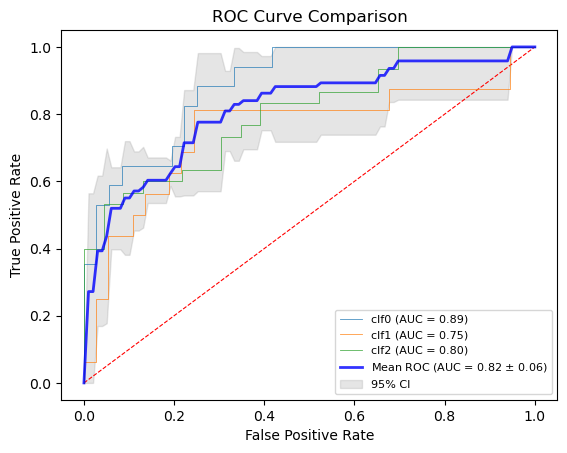

##############
The best parameters are {'max_depth': 12, 'min_child_weight': 0.7, 'n_estimators': 20, 'scale_pos_weight': 2.4} with a score of 0.65
XB 0.74


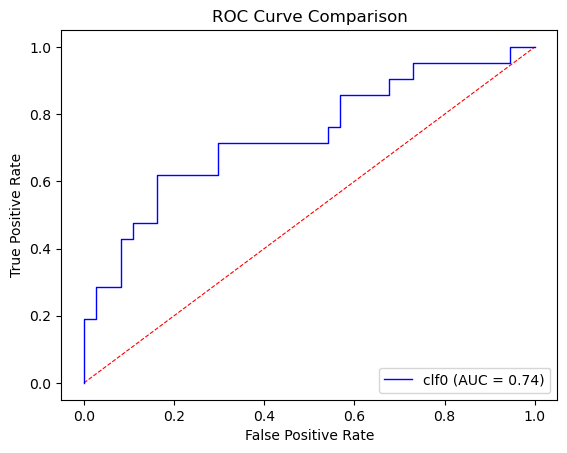

In [11]:
#最终画图
import warnings
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in [1]:#range(0,50):#[1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    
    
    auc_record = []
    #"""

    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label="95% CI")#r'$\pm$ 1 std. dev.'


        ax.legend(loc="lower right",fontsize=8)

        plt.title('ROC Curve Comparison')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        #------------------------------------------
    #"""
    
    #"""
    auc_record_ = []
    print("##############")
    for i in ["XB"]:#["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for i in range(1):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=1, linewidth=1, color='b')

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        #std_auc = np.std(aucs)
        #ax.plot(mean_fpr, mean_tpr, color='b',
        #        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        #        lw=2, alpha=.8)

        #std_tpr = np.std(tprs, axis=0)
        #tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        #tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        #ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #               label="95% CI")#r'$\pm$ 1 std. dev.'


        #ax.legend(loc="lower right",fontsize=8)

        plt.title('ROC Curve Comparison')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        #------------------------------------------
        
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""
    #input()

----------------------------seed: 1
样本总数： 160
划分后每折样本数： 53
##############
The best parameters are {'C': 1, 'kernel': 'poly'} with a score of 0.65
SVC 0.72
The best parameters are {'C': 5, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} with a score of 0.64
LR 0.63
The best parameters are {'n_neighbors': 12} with a score of 0.59
KNN 0.62
The best parameters are {} with a score of 0.57
NB 0.66
The best parameters are {'criterion': 'entropy', 'max_depth': 10, 'min_impurity_decrease': 0.001, 'min_samples_leaf': 5, 'min_samples_split': 20} with a score of 0.61
DT 0.67
The best parameters are {'criterion': 'gini', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 15} with a score of 0.70
RF 0.74
The best parameters are {'max_depth': 12, 'min_child_weight': 0.7, 'n_estimators': 20, 'scale_pos_weight': 2.4} with a score of 0.65
XB 0.74


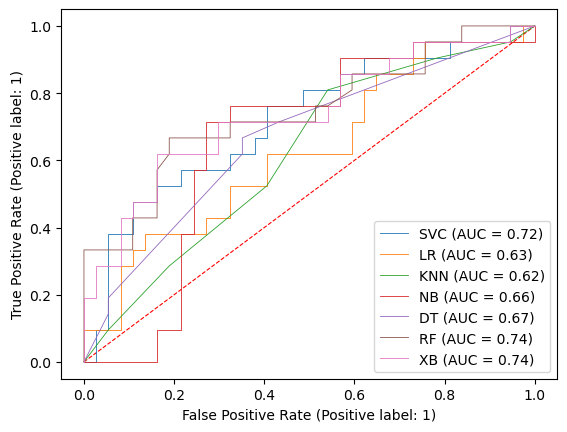

In [23]:
#最终画图
import warnings
from sklearn.metrics import roc_curve, auc
warnings.filterwarnings("ignore")

tp1 = []
tp2 = []
#num = 10
for s in [1]:#range(0,50):#[1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    
    
    
    auc_record = []
    """

    for i in ["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        # 画 ROC 曲线
        fig, ax = plt.subplots()
        ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0,1, 100)

        for i in range(3):
            clf0,X0,y0 = train_model(data_num=i,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name='clf'+str(i), ax=ax, alpha=0.8, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)    
        
        auc_record.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        std_auc = np.std(aucs)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label="95% CI")#r'$\pm$ 1 std. dev.'


        ax.legend(loc="lower right",fontsize=8)

        plt.title('ROC Curve Comparison')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        #------------------------------------------
    #"""
    
    #"""
    # 画 ROC 曲线
    fig, ax = plt.subplots()
    ax.plot([0,1],[0,1],linestyle='--',color='r',linewidth=0.8)#对角线
    
    auc_record_ = []
    print("##############")
    for i in ["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:
        
        name = i

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        for j in range(1):
            clf0,X0,y0 = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            viz = RocCurveDisplay.from_estimator(clf0, X0, y0, name=str(i), ax=ax, alpha=1, linewidth=0.6)

            interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            aucs.append(viz.roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        
        auc_record_.append(mean_auc)
        print(name,round(mean_auc,2))
        
        
        #----------------------------------------
        #std_auc = np.std(aucs)
        #ax.plot(mean_fpr, mean_tpr, color='b',
        #        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        #        lw=2, alpha=.8)

        #std_tpr = np.std(tprs, axis=0)
        #tprs_upper = np.minimum(mean_tpr + 1.96*std_tpr, 1)
        #tprs_lower = np.maximum(mean_tpr - 1.96*std_tpr, 0)
        #ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
        #               label="95% CI")#r'$\pm$ 1 std. dev.'


        #ax.legend(loc="lower right",fontsize=8)
        #------------------------------------------
        

    #plt.title('ROC Curve Comparison')
    #plt.xlabel('False Positive Rate')
    #plt.ylabel('True Positive Rate')
    plt.show()
    
    tp1.append(auc_record)
    tp2.append(auc_record_)
    #"""
    #input()

In [ ]:


# 预测概率
y_prob = model.predict_proba(X_test)[:, 1]

# AUC
auc = roc_auc_score(y_test, y_prob)

# 预测类别
y_pred = model.predict(X_test)

# 准确率
accuracy = accuracy_score(y_test, y_pred)

# 混淆矩阵
conf_matrix = confusion_matrix(y_test, y_pred)

# True Positive, False Negative, False Positive, True Negative
TP = conf_matrix[1, 1]
FN = conf_matrix[1, 0]
FP = conf_matrix[0, 1]
TN = conf_matrix[0, 0]

# 召回率 (Recall)
recall = recall_score(y_test, y_pred)

# 特异度 (Specificity)
specificity = TN / (TN + FP)

# F1 分数
f1 = f1_score(y_test, y_pred)


In [32]:
#-------------------------------这个是用来算其他指标的
warnings.filterwarnings("ignore")
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, confusion_matrix, f1_score
tp1 = []
tp2 = []
#num = 10
for s in [1]:#
    print("----------------------------seed:",s)
    train,test = get_train_test(df=df,fold=3,seed=s)
    print("##############")
    
    acc_ = []
    recal_ = []
    spec_ = []
    f1_ = []
    matrix = []
    for i in ["SVC", "LR", "KNN", "NB", "DT", "RF", "XB"]:#

        #训练数据
        fold = 3
        target_name = "随访>=3"
        model_name = i#"RF"#SVC LR KNN NB DT RF XB

        model,X_test,y_test = train_model_(df1=df1,df2=df2,target_name=target_name,name=model_name)
            
        # 预测概率---------------------------------------
        #y_prob = model.predict_proba(X_test)[:, 1]
        y_prob = model.predict(X_test)

        # AUC
        #auc = roc_auc_score(y_test, y_prob)

        # 预测类别
        y_pred = model.predict(X_test)

        # 准确率
        accuracy = accuracy_score(y_test, y_pred)

        # 混淆矩阵
        conf_matrix = confusion_matrix(y_test, y_pred)

        # True Positive, False Negative, False Positive, True Negative
        TP = conf_matrix[1, 1]
        FN = conf_matrix[1, 0]
        FP = conf_matrix[0, 1]
        TN = conf_matrix[0, 0]

        # 召回率 (Recall)
        recall = recall_score(y_test, y_pred)

        # 特异度 (Specificity)
        specificity = TN / (TN + FP)

        # F1 分数----------------------------------------------
        f1 = f1_score(y_test, y_pred)
    
        
        print(model_name,round(accuracy,2),round(recall,2),round(specificity,2),round(f1,2))
        print(conf_matrix)
        acc_.append(round(accuracy,2))
        recal_.append(round(recall,2))
        spec_.append(round(specificity,2))
        f1_.append(round(f1,2))
        matrix.append(conf_matrix)
        
    tp1.append(auc_record)
    tp2.append(auc_record_)

----------------------------seed: 1
样本总数： 160
划分后每折样本数： 53
##############
SVC 0.62 0.0 0.97 0.0
[[36  1]
 [21  0]]
LR 0.67 0.29 0.89 0.39
[[33  4]
 [15  6]]
KNN 0.64 0.1 0.95 0.16
[[35  2]
 [19  2]]
NB 0.57 0.19 0.78 0.24
[[29  8]
 [17  4]]
DT 0.66 0.67 0.65 0.58
[[24 13]
 [ 7 14]]
RF 0.71 0.48 0.84 0.54
[[31  6]
 [11 10]]
XB 0.69 0.62 0.73 0.59
[[27 10]
 [ 8 13]]


In [33]:
acc_

[0.62, 0.67, 0.64, 0.57, 0.66, 0.71, 0.69]

In [34]:
recal_

[0.0, 0.29, 0.1, 0.19, 0.67, 0.48, 0.62]

In [35]:
spec_

[0.97, 0.89, 0.95, 0.78, 0.65, 0.84, 0.73]

In [36]:
f1_

[0.0, 0.39, 0.16, 0.24, 0.58, 0.54, 0.59]

In [37]:
matrix

[array([[36,  1],
        [21,  0]], dtype=int64),
 array([[33,  4],
        [15,  6]], dtype=int64),
 array([[35,  2],
        [19,  2]], dtype=int64),
 array([[29,  8],
        [17,  4]], dtype=int64),
 array([[24, 13],
        [ 7, 14]], dtype=int64),
 array([[31,  6],
        [11, 10]], dtype=int64),
 array([[27, 10],
        [ 8, 13]], dtype=int64)]